# Turrial: How to use geneGATer

geneGATer is a Python package designed to facilitate the identification and ranking of potential communication genes from spatial transcriptomics data. The package integrates an adapted metagene construction method by Hue et. al. [2022] and a Graph Attention Network (GAT) to enable the exploration of cell-to-cell communication without relying on explicit cell-type annotations.

First we need to download the latest build of the package from the geneGATer github repo, if we haven't done so yet:

In [ ]:
!python -m pip install git+https://github.com/dertrotl/geneGATer.git@main

In [2]:
import geneGATer as gt
import squidpy as sq
import numpy as np
import pandas as pd
import scanpy as sc

/Users/benjaminweinert/opt/miniconda3/envs/genegater/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We demonstrate the geneGATer pipeline on the squidpy coronal mouse brain section Visium dataset. The turorial is split in two parts. In part one, we apply the {func}`gt.tl.getComGenes` function, to extract the potential communication gene candidates. In part two, we show how we can use geneGATer to learn a graph attention model (GAT) to extract the most "influential" genes by ranking them. We start by loading the dataset and preprocessing it.

In [3]:
adata = sq.datasets.visium_hne_adata()
adata.raw = adata
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.neighbors(adata)

## Part I

Next we apply a standard pre-clustering. The "cluster-key" parameter specifies where to store the clusterin in the adata.obs section.

In [4]:
new_cluster = gt.pp.pre_clustering(adata, cluster_key = "new_cluster", resolution = 1)

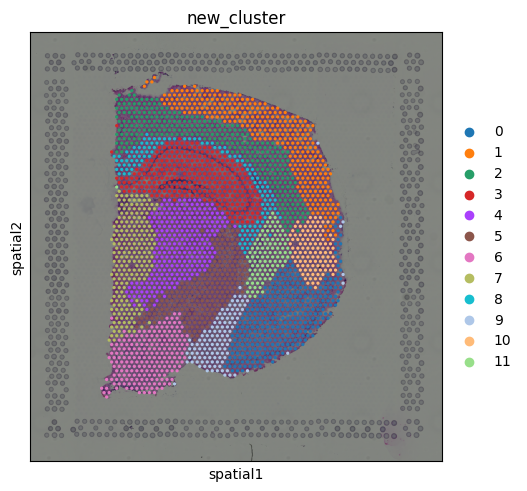

In [5]:
sq.pl.spatial_scatter(adata, color="new_cluster")

We see, that we clustered our spots in 12 different regions. Next, we want to extract potential communication candidates by building metagenes for each cluster in our pre-clustering. For this, we have to input our adata object and the pre-clustering from the first steps. This will take some minutes.

In [6]:
result = gt.tl.getComGenes(adata, new_cluster, tresh=0.0, groupby="new_cluster", verbosse = False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.75s/it]


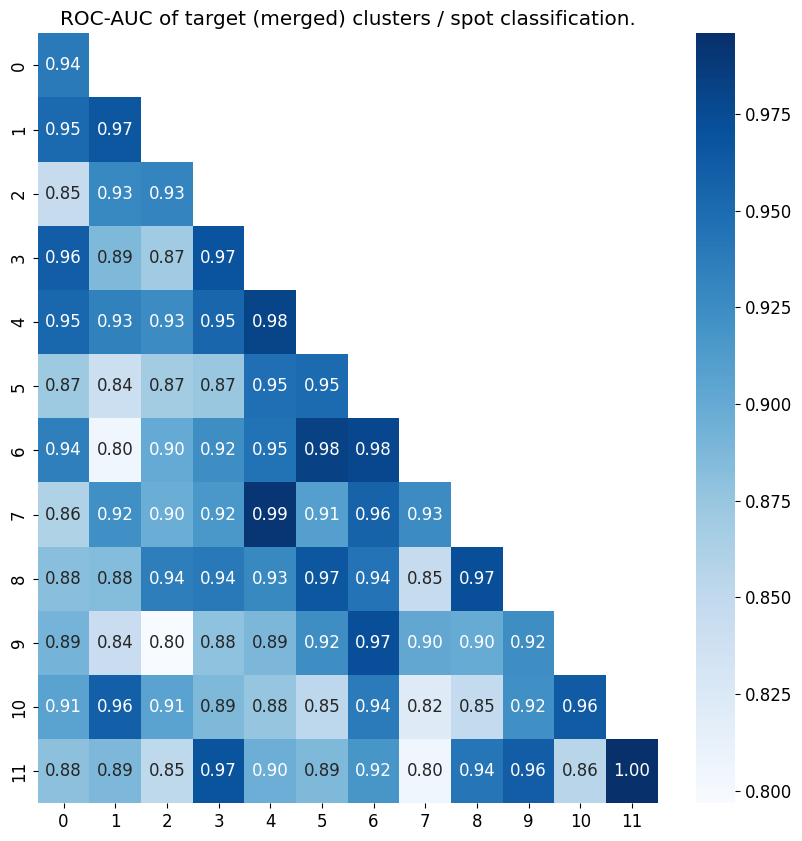

In [7]:
plot = gt.pl.roc_auc_classification(adata=adata, all_metas = result[2], raw_cluster=new_cluster)

"result" saves multiple outputs, indexing "result[2]" gives us the metagene expression of each cluster for each spot. To validate the results of our metagenes, we plotted the above matrix, which highlights the roc-auc scores of the spot clustering by metagenes. 

## Part II

Next, we want to train a GAT model to rank the our communication candidates by their importance, according to our model and validate these results. We do this by simply running the {func}`gt.tl.learn_model` function and setting a model type and loss function (nn negative binomial, nn poisson or mse loss). For this we need a list of genes, which are ideally the genes we extracted in part I (stored in "result[4]").

In [7]:
np.save('squid_genes.npy', result[4]) 

In [8]:
gene_list = result[4]

In [9]:
model, data = gt.tl.learn_model(adata, gene_list = gene_list, model_type = "GAT", loss = "mse", epochs = 100)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


GAT(
  (conv1): GATv2Conv(293, 293, heads=1)
  (conv2): GATv2Conv(293, 18078, heads=1)
)


 10%|██████████▌                                                                                              | 10/100 [01:57<17:39, 11.77s/it]

Epoch:  10.0  Loss:  9.472657203674316


 20%|█████████████████████                                                                                    | 20/100 [03:35<14:26, 10.83s/it]

Epoch:  20.0  Loss:  1.3256076574325562


 30%|███████████████████████████████▌                                                                         | 30/100 [05:25<14:37, 12.54s/it]

Epoch:  30.0  Loss:  0.6214395761489868


 40%|██████████████████████████████████████████                                                               | 40/100 [07:18<13:12, 13.21s/it]

Epoch:  40.0  Loss:  0.47567155957221985


 50%|████████████████████████████████████████████████████▌                                                    | 50/100 [09:07<10:11, 12.23s/it]

Epoch:  50.0  Loss:  0.14159516990184784


 60%|███████████████████████████████████████████████████████████████                                          | 60/100 [11:04<08:36, 12.91s/it]

Epoch:  60.0  Loss:  0.10813288390636444


 70%|█████████████████████████████████████████████████████████████████████████▌                               | 70/100 [13:03<06:13, 12.45s/it]

Epoch:  70.0  Loss:  0.07258807122707367


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 80/100 [14:59<03:56, 11.81s/it]

Epoch:  80.0  Loss:  0.0632665753364563


 90%|██████████████████████████████████████████████████████████████████████████████████████████████▌          | 90/100 [17:03<01:57, 11.78s/it]

Epoch:  90.0  Loss:  0.06014275178313255


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [18:44<00:00, 11.25s/it]


Test Eval Error,█▂▂▁▁▁▁▁▁▁
Test R2,▁▇▇███████
Test R2_lin,▁▁▂▄▄▆▇███
Train Eval Error,█▂▂▁▁▁▁▁▁▁
Train R2,▁▇▇███████
Train R2_lin,▁▁▂▄▄▆▇███
Validation Eval Error,█▂▂▁▁▁▁▁▁▁
Validation R2,▁▆▇███████
Validation R2_lin,▁▁▂▄▄▆▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█▂▂▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


For monitoring the learning performance, we use "weights & biases" (wandb). The results and the progress is directly uploaded to a wandb instance. Furthermore, we can analyse our results by using some of the plotting functions of this package. (The results indicated here can be significantly improved by learning up to 1000 epochs.)

(<Figure size 1000x1000 with 1 Axes>,
 array([[5.2995124, 4.820972 ],
        [4.659695 , 4.6405478],
        [4.6481504, 4.5228744],
        ...,
        [2.0355809, 4.9695773],
        [6.297827 , 5.3710666],
        [6.3939495, 1.6471777]], dtype=float32))

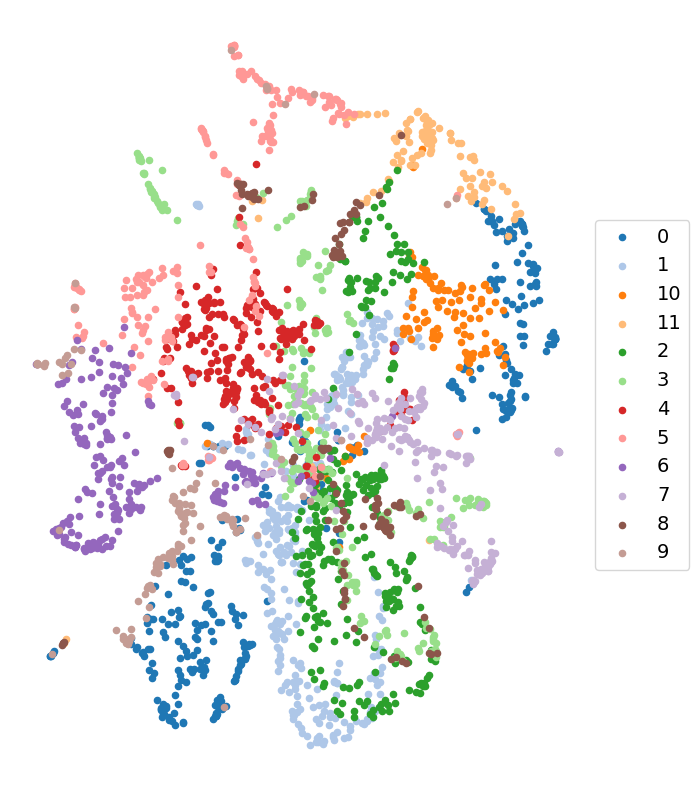

In [10]:
gt.pl.attention_umap(model, data, adata, n_components=700, cluster_key="new_cluster", umap_model="umap") #tsne works as well

We can get the top ranked genes by two different ranking methods:
    
1. Using classical saliancy scores using the {func}`gt.pl.get_top_k_genes_saliency` function.
2. Using receiving and sending weight signals using the {func}`gt.pl.get_top_k_genes` function.

Furthermore we can compare the top ranked genes by a list of marker genes. In this tutorial, we want to compare our results with found ligand and receptor interactions using the CellphoneDB implementation in Squidpy. Genes which are also present in the marker gene list, are marked with an asterisk (*).

In [11]:
# Extracting L&R interactions using CellphoneDB and Squidpy

adata.obs["new_cluster"] = new_cluster
res = sq.gr.ligrec(adata, "new_cluster",
            fdr_method=None,
                   copy=True,
            interactions_params={"resources": "CellPhoneDB"},
            threshold=0.1, seed=0, n_perms=10000, n_jobs=1, use_raw=False) 

df = res["pvalues"]
print("Number of CellPhoneDB interactions:", len(df))

ligand_receptor_space = []

for tuples in range(0,res["metadata"].index.values.shape[0]):
    for idx in range(0,2):
        ligand_receptor_space.append(res["metadata"].index.values[tuples][idx])
ligand_receptor_space = list( set(ligand_receptor_space) )
print("Number of unique Ligand / Receptor Genes:", len(ligand_receptor_space))


gene_list_upper = [x.upper() for x in gene_list]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 812.66permutation/s]


Number of CellPhoneDB interactions: 654
Number of unique Ligand / Receptor Genes: 493


(<Figure size 1000x600 with 1 Axes>,
   all_genes
 0     PVALB
 1       NOV
 2     TYRO3
 3     CABP7
 4     RAB3C
 5   ST6GAL2
 6    SH3GL3
 7   CAMK2N1
 8     SEPT8
 9      RPS8)

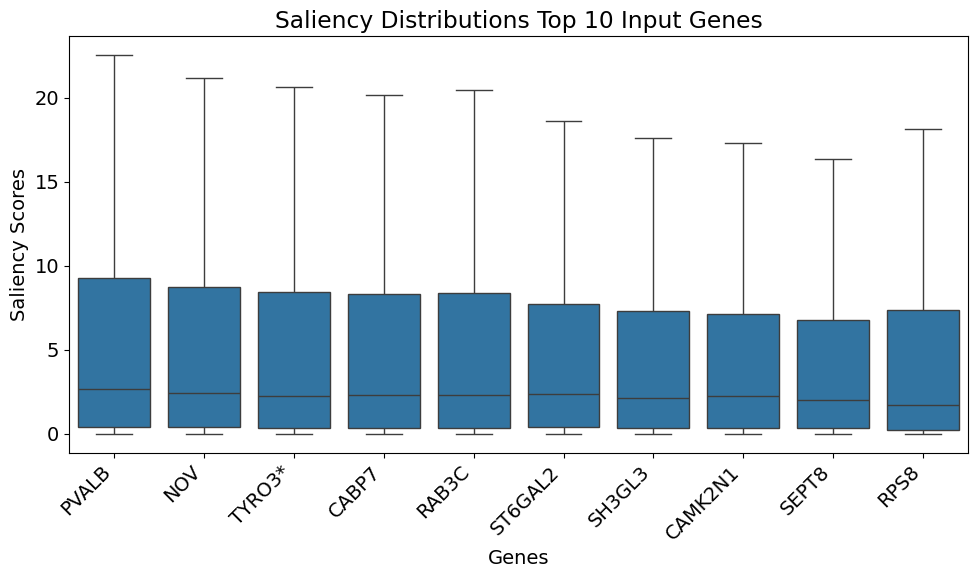

In [12]:
gt.pl.get_top_k_genes_saliency(model, data, gene_list_upper, 10, marker_genes = ligand_receptor_space) # Plotting ranked genes by ranking method 1

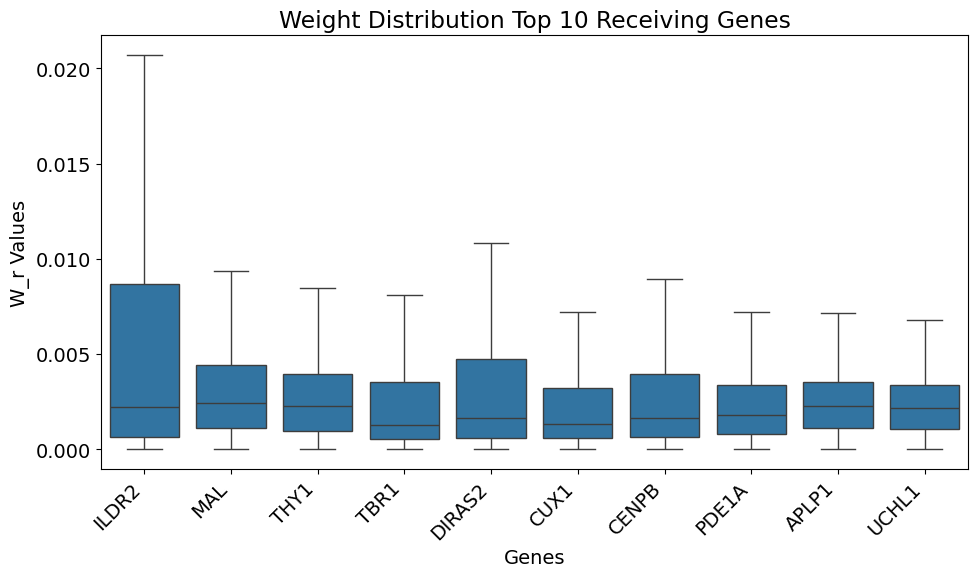

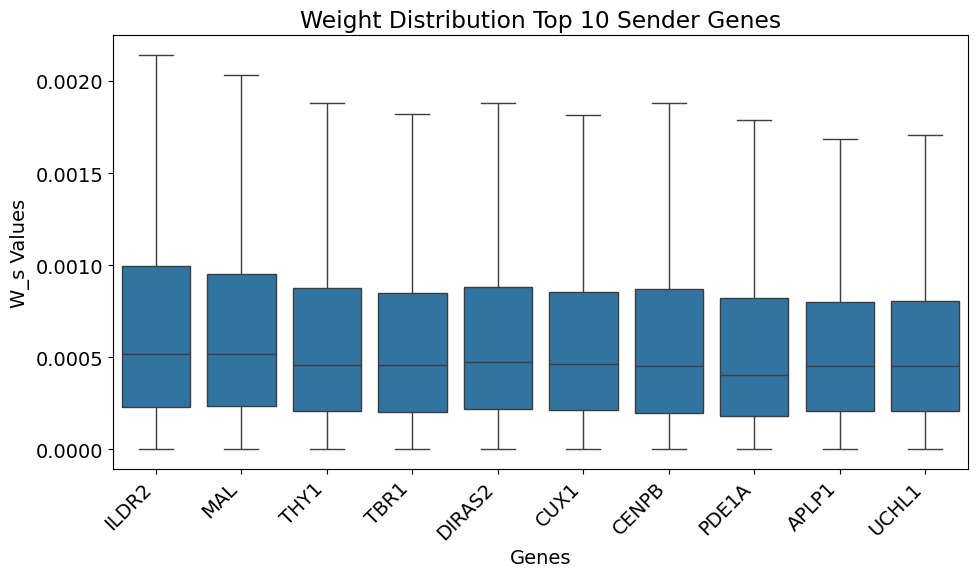

In [13]:
res = gt.pl.get_top_k_genes(model, gene_list_upper, 10, marker_genes = ligand_receptor_space) # Plotting ranked genes by ranking method 2

More plotting functions can be found in the documentation.